In [ ]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataset

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
layer_ann = nn.Linear(64, 16*4)

# batch, word_sequence, embedding
x = torch.rand(16, 256,  64)
subres = layer_ann(x)
print(f"subres: {subres.shape}")

# batch, words_sequence, n_heads, dim_head
subres = subres.view(16, 256, 4, 16)
print(f"subres: {subres.shape}")

# batch, n_heads, words_sequence, dim_head
subres = subres.transpose(2,1)
print(f"subres: {subres.shape}")

subres: torch.Size([16, 256, 64])
subres: torch.Size([16, 256, 4, 16])
subres: torch.Size([16, 4, 256, 16])


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_k, d_model, n_heads):
        super().__init__()

        # assert (d_k * n_heads == d_model)
        # assume d_v = d_k
        self.d_k = d_k
        self.n_heads = n_heads

        self.key = nn.Linear(d_model, d_k * n_heads)
        self.query = nn.Linear(d_model, d_k * n_heads)
        self.value = nn.Linear(d_model, d_k * n_heads)
        # self.jei = nn.Linear(d_model, d_k * n_heads)

        self.fc = nn.Linear(d_k * n_heads, d_model)


    def forward(self, q, k, v, j, mask=None):
        q = self.query(q) # input q(N x T x d_model)  output q(N x T x (h*d_k))
        k = self.key(k)
        v = self.value(v)
        # j = self.jei(j)

        N = q.shape[0]
        T = q.shape[1]

        # change the shape to (N, T, h, d_k) -> (N, h, T, d_k)
        q = q.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
        k = k.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
        v = v.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
        # j = j.view(N, T, self.n_heads, self.d_k).transpose(1, 2)

        # (q)(N , h, T, d_k) x (k)(N, h, d_k, T) --> (N, h, T, T)
        attn_scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)
        # attn_scores_j = q @ j.transpose(-2, -1) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask[:, None, None, :] == 0, float('-inf'))
            # attn_scores_j = attn_scores_j.masked_fill(mask[:, None, None, :] == 0, float('-inf'))

        attn_weights = F.softmax(attn_scores, dim=-1)
        # attn_scores_j = F.softmax(attn_scores_j, dim=-1)

        # compute attention-weighted values
        # (N, h, T, T) x (N, h, T, d_k) -> (N, h, T, d_k)
        # sub_a = attn_weights @ attn_scores_j
        A = attn_weights @ v

        # reshape back (N, T, h, d_k)
        A = A.transpose(1, 2)

        # (N, T, h*d_k)
        A = A.contiguous().view(N, T, self.d_k * self.n_heads)

        return self.fc(A)


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, d_k, d_model, n_heads, dropout_prob=0.1):
        super().__init__()

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_k, d_model, n_heads)
        self.ann = nn.Sequential(
            nn.Linear(d_model, d_model*4),
            nn.GELU(),
            nn.Linear(4*d_model, d_model),
            nn.Dropout(dropout_prob))
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x, mask=None):
        x = self.ln1(x + self.mha(x, x, x, mask))
        x = self.ln2(x + self.ann(x))
        x = self.dropout(x)
        return x

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2048, dropout_prob=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_prob)

        position = torch.arange(max_len).unsqueeze(1)
        exp_term = torch.arange(0, d_model, 2)
        div_term = torch.exp(exp_term * (-math.log(10000.0) / d_model ))
        pe = torch.zeros(1, max_len, d_model)

        pe[0, :, 0::2] = torch.sin(position*div_term)
        pe[0, :, 1::2] = torch.cos(position*div_term)

        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)



In [ ]:
# a = torch.zeros(1, 2048, 512)

In [ ]:
# [1,2,3,4,5,6,7,8][0::2]

In [ ]:
class Encoder(nn.Module):
    def __init__(
        self, vocab_size, max_len, d_k, d_model,
        n_heads, n_layers, n_classes, dropout_prob
    ):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
        transformers_blocks = [
            TransformerBlock(d_k, d_model, n_heads, dropout_prob)
            for _ in range(n_layers)
        ]
        self.transformer_blocks = nn.Sequential(*transformers_blocks)
        self.ln = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, n_classes)

    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)

        for block in self.transformer_blocks:
            x = block(x, mask)

        x = x[:, 0, :]
        x = self.ln(x)
        x = self.fc(x)

        return x

In [ ]:
VOCAB_SIZE = 20_000
MAX_LENGTH = 1024
QK_SIZE = 16
EMBED_SIZE = 64
N_HEADS = 4
N_LAYERS = 2
NUM_CLASSES = 30
DROPOUT= 0.1


model = Encoder(VOCAB_SIZE, MAX_LENGTH, QK_SIZE, EMBED_SIZE, N_HEADS, N_LAYERS,
                NUM_CLASSES, DROPOUT)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


Encoder(
  (embedding): Embedding(20000, 64)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
      )
      (ann): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=256, out_features=64, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (ln1): LayerNorm((64,), eps=1e-05, 

In [ ]:
x = np.random.randint(0,20000, size=(8, 512))

x_t = torch.tensor(x).to(device)

In [ ]:
x

array([[19697,  9473,  7493, ..., 10067, 13291, 15391],
       [ 9649,  3796,  1873, ...,  6092,  4502, 14782],
       [ 9845, 12220,  1644, ..., 18618, 18905, 14466],
       ...,
       [ 2570, 11865, 16558, ...,   404,  8959,  9444],
       [ 1983, 12641,  8856, ..., 14476,  4711, 14151],
       [16360, 16117,  5130, ..., 18050,  9055, 12365]])

In [ ]:
mask = np.ones((8,512))
mask[:, 256:] = 0
mask_t = torch.tensor(mask).to(device) 

In [ ]:
y = model(x_t, mask_t)

In [ ]:
y

tensor([[-1.3652e+00, -3.6415e-01,  5.8660e-01,  1.8858e-01,  3.7672e-01,
         -7.7631e-01,  1.2521e+00, -4.5006e-01,  2.6967e-01,  5.8954e-01,
         -7.4284e-01, -5.4973e-01, -1.0331e+00, -3.4260e-01,  2.9832e-01,
          4.0236e-01, -9.3772e-01, -4.0622e-01, -5.3549e-04, -5.0691e-01,
         -2.7163e-01,  1.9332e-01, -4.5022e-01,  5.2661e-01,  6.8135e-01,
          2.3464e-01,  4.4524e-01, -3.0130e-01,  1.2645e+00,  7.6252e-01],
        [-1.3716e+00, -6.9358e-01,  3.3816e-01,  1.7799e-01,  2.3317e-01,
         -4.9151e-01,  8.7390e-01,  2.2335e-01, -6.6403e-02, -1.2787e+00,
         -9.7839e-01,  6.9265e-02, -7.0867e-02, -2.8824e-01,  8.8435e-02,
         -1.5626e+00,  6.7971e-01,  1.2256e+00, -2.5968e-01,  2.3403e-01,
         -4.8880e-01,  5.4615e-02,  1.0746e-01, -1.1161e+00, -1.5710e-01,
          5.7356e-01,  9.4256e-01, -2.6772e-01,  3.1268e-01,  7.4804e-03],
        [-9.5274e-01, -2.4694e-01,  4.3472e-01,  1.0528e-01,  6.7036e-01,
          8.8951e-02, -7.3701e-01,  

In [ ]:
%%capture
!pip install transformers datasets evaluate

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding

from transformers import BertTokenizerFast

checkpoint = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# checkpoint = 'distilbert-base-cased'
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
# from datasets import load_dataset

# raw_dataset = load_dataset('glue', 'sst2')

In [ ]:
from datasets import load_dataset

dataset = load_dataset("amazon_reviews_multi", "en")

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
df_imdb_train = dataset['train'].to_pandas()
df_imdb_val = dataset['validation'].to_pandas()


df_imdb_train.sample(10)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
30209,en_0344562,product_en_0761384,reviewer_en_0465507,1,I bought these just after Christmas and now no...,Doesn’t work,en,wireless
47316,en_0794588,product_en_0068197,reviewer_en_0908097,2,Bought it end of Jan. 2019... by march limited...,Not a good choice...Wont charge after 2 to 3 m...,en,drugstore
188121,en_0001372,product_en_0595177,reviewer_en_0648789,5,Yummy!!!! My whole family enjoyed drinking thi...,My whole family enjoyed drinking this tea,en,drugstore
194171,en_0796778,product_en_0287442,reviewer_en_0632967,5,"No bubbles; however, I bought two: one for the...",Best bang for your buck!!,en,wireless
38520,en_0030047,product_en_0118180,reviewer_en_0368678,1,"My product arrived on time, but was missing th...",The box was not sealed so I suspect the bolts ...,en,automotive
109465,en_0342784,product_en_0547362,reviewer_en_0040297,3,The seam on the back end of the pillowcases we...,The seam on the back end of the pillowcases we...,en,home
62832,en_0881797,product_en_0318351,reviewer_en_0771588,2,"Product is okay, but at some point it seems li...","ok, but wish i had found something better",en,home_improvement
15959,en_0961819,product_en_0180179,reviewer_en_0626986,1,The advertised picture & the balloons you rece...,Yellow Balloons,en,toy
95680,en_0718804,product_en_0038434,reviewer_en_0282797,3,Does not stick to table so it defeats the whol...,I do not recommend,en,baby_product
43403,en_0115915,product_en_0397786,reviewer_en_0582125,2,The color was nice. It didn’t feel drying. How...,Came off easy. Had to reapply throughout day,en,beauty


In [ ]:
maps_cart = {indx: i for i,indx in enumerate(df_imdb_train['product_category'].value_counts().index)}

df_imdb_train['product_category'] = df_imdb_train['product_category'].apply(lambda x: maps_cart[x])
df_imdb_val['product_category'] = df_imdb_val['product_category'].apply(lambda x: maps_cart[x])

In [ ]:
df_imdb_train['stars'] = df_imdb_train['stars'].apply(lambda x: int(x))
df_imdb_val['stars'] = df_imdb_val['stars'].apply(lambda x: int(x))

df_imdb_train['fulltext'] = df_imdb_train['review_title'] + " [sep] " + df_imdb_train['review_body']
df_imdb_val['fulltext'] = df_imdb_val['review_title'] + " [sep] " + df_imdb_val['review_body']

df_imdb_train['charLen'] = df_imdb_train['fulltext'].apply(lambda x: len(x))
df_imdb_val['charLen'] = df_imdb_val['fulltext'].apply(lambda x: len(x))


df_imdb_train['wordLen'] = df_imdb_train['fulltext'].apply(lambda x: len(x.split()))
df_imdb_val['wordLen'] = df_imdb_val['fulltext'].apply(lambda x: len(x.split()))

In [ ]:
df_imdb_train.sample(5)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,fulltext,charLen,wordLen
181121,en_0674693,product_en_0486613,reviewer_en_0085614,5,This is a value-for-money signal detector. As ...,"Great service, great product! Cost-effective d...",en,23,"Great service, great product! Cost-effective d...",221,35
90781,en_0032459,product_en_0883797,reviewer_en_0693421,3,I'm going to return it. A 12 second delay in t...,Time delay,en,11,Time delay [sep] I'm going to return it. A 12 ...,92,19
144862,en_0995354,product_en_0001986,reviewer_en_0105222,4,Product arrived on time. Works great for my ap...,Good product,en,11,Good product [sep] Product arrived on time. Wo...,149,25
167683,en_0168023,product_en_0057499,reviewer_en_0064905,5,Better than expected,Good quality,en,14,Good quality [sep] Better than expected,39,6
47096,en_0716051,product_en_0097293,reviewer_en_0870777,2,Ised it to flash cure gel on nails. It worked ...,Short life,en,4,Short life [sep] Ised it to flash cure gel on ...,117,23


<Axes: >

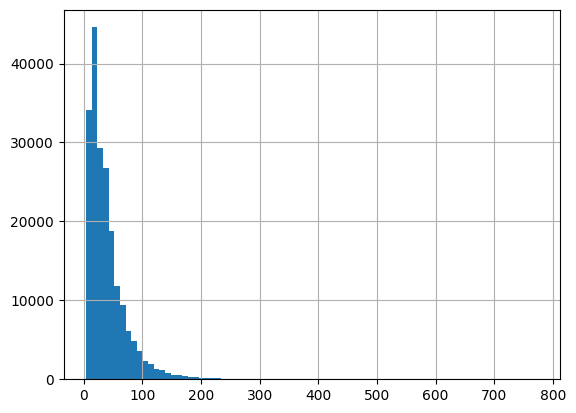

In [ ]:
df_imdb_train['wordLen'].hist(bins=80)

<Axes: >

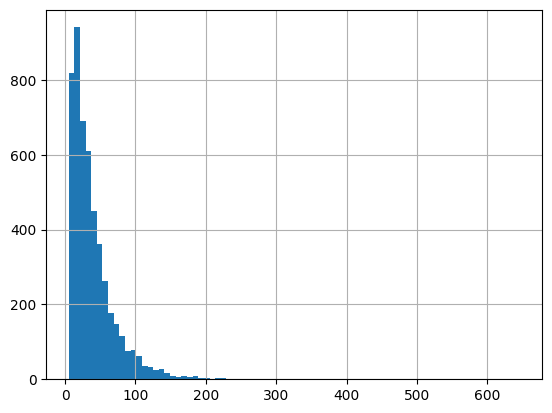

In [ ]:
df_imdb_val['wordLen'].hist(bins=80)

In [ ]:
df_imdb_train['wordLen'].describe()

count    200000.000000
mean         39.639920
std          35.215934
min           4.000000
25%          17.000000
50%          30.000000
75%          50.000000
max         773.000000
Name: wordLen, dtype: float64

In [ ]:
df_imdb_val['wordLen'].describe()

count    5000.000000
mean       40.042800
std        36.957724
min         5.000000
25%        17.000000
50%        30.000000
75%        51.000000
max       646.000000
Name: wordLen, dtype: float64

<Axes: >

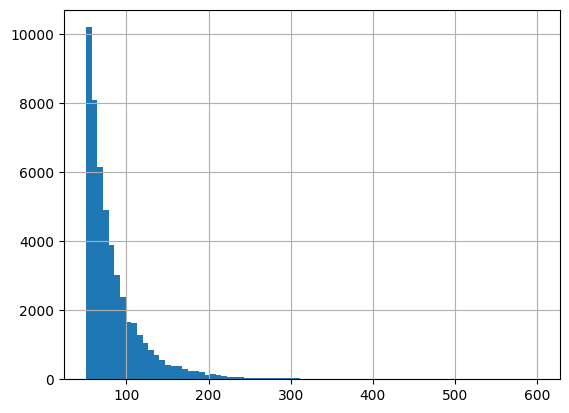

In [ ]:
df_imdb_train[((df_imdb_train['wordLen'] > 50) & (df_imdb_train['wordLen'] < 640))]['wordLen'].hist(bins=80)

In [ ]:
df_imdb_train[((df_imdb_train['wordLen'] > 50) & (df_imdb_train['wordLen'] < 640))]['wordLen'].describe()

count    49734.000000
mean        85.189066
std         41.836625
min         51.000000
25%         59.000000
50%         72.000000
75%         95.000000
max        600.000000
Name: wordLen, dtype: float64

In [ ]:
# df_imdb_train = df_imdb_train[df_imdb_train['wordLen'] < 128]
# df_imdb_val = df_imdb_val[df_imdb_val['wordLen'] < 128]

In [ ]:
from datasets import Dataset, DatasetDict

In [ ]:
tds = Dataset.from_pandas(df_imdb_train)
vds = Dataset.from_pandas(df_imdb_val)

dataset = DatasetDict()

dataset['train'] = tds
dataset['validation'] = vds

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category', 'fulltext', 'charLen', 'wordLen'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category', 'fulltext', 'charLen', 'wordLen'],
        num_rows: 5000
    })
})


In [ ]:
def tokenize_fn(batch):
    return tokenizer.batch_encode_plus(batch['fulltext'], max_length=128, padding='max_length', truncation=True)

In [ ]:
tokenizer.max_model_input_sizes[checkpoint]

512

In [ ]:
from datasets import ClassLabel


def map_start_to_label(review):
  if review["stars"] < 3:
    review["stars"] = 0
  elif review["stars"] == 3:
    review["stars"] = 1
  else:
    review["stars"] = 2
  return review

# convert 1-5 star reviews to 0,1,2
dataset = dataset.map(map_start_to_label)

# convert feature from Value to ClassLabel
class_feature =  ClassLabel(names=['negative','neutral', 'positive'])
dataset = dataset.cast_column("stars", class_feature)

# rename our target column to labels

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/200000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets = dataset.map(tokenize_fn, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
data_collator

DataCollatorWithPadding(tokenizer=BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(['review_id', 'product_id', 'reviewer_id', 'review_body', 'review_title', 'language', 'product_category', 'fulltext', 'charLen', 'wordLen',])
tokenized_datasets = tokenized_datasets.rename_column("stars", "labels")

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5000
    })
})

In [ ]:
len(set(tokenized_datasets['validation']['labels']))

3

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    tokenized_datasets['train'],
    shuffle=True,
    batch_size=32,
    collate_fn=data_collator
)

valid_loader = DataLoader(
    tokenized_datasets['validation'],
    batch_size=32,
    collate_fn=data_collator
)

In [ ]:
for batch in train_loader:
    # print(batch)
    for k, v in batch.items():
        print("k:", k, 'v.shape:', v.shape)
    break

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


k: labels v.shape: torch.Size([32])
k: input_ids v.shape: torch.Size([32, 512])
k: token_type_ids v.shape: torch.Size([32, 512])
k: attention_mask v.shape: torch.Size([32, 512])


In [ ]:
set(tokenized_datasets['train']['labels'])
tokenizer.vocab_size

30522

In [ ]:
tokenizer.max_model_input_sizes

{'bert-base-uncased': 512,
 'bert-large-uncased': 512,
 'bert-base-cased': 512,
 'bert-large-cased': 512,
 'bert-base-multilingual-uncased': 512,
 'bert-base-multilingual-cased': 512,
 'bert-base-chinese': 512,
 'bert-base-german-cased': 512,
 'bert-large-uncased-whole-word-masking': 512,
 'bert-large-cased-whole-word-masking': 512,
 'bert-large-uncased-whole-word-masking-finetuned-squad': 512,
 'bert-large-cased-whole-word-masking-finetuned-squad': 512,
 'bert-base-cased-finetuned-mrpc': 512,
 'bert-base-german-dbmdz-cased': 512,
 'bert-base-german-dbmdz-uncased': 512,
 'TurkuNLP/bert-base-finnish-cased-v1': 512,
 'TurkuNLP/bert-base-finnish-uncased-v1': 512,
 'wietsedv/bert-base-dutch-cased': 512}

In [ ]:
VOCAB_SIZE = tokenizer.vocab_size
# MAX_LENGTH = tokenizer.max_model_input_sizes[checkpoint]
MAX_LENGTH = 128
QK_SIZE = 16
EMBED_SIZE = 128
N_HEADS = 3
N_LAYERS = 2
NUM_CLASSES = len(set(tokenized_datasets['validation']['labels'])) + 1
DROPOUT= 0.1

In [ ]:
model = Encoder(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LENGTH,
    d_k=QK_SIZE,
    d_model=EMBED_SIZE,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    n_classes=NUM_CLASSES,
    dropout_prob=DROPOUT
)
model.to(device)

Encoder(
  (embedding): Embedding(30522, 128)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.15, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (key): Linear(in_features=128, out_features=48, bias=True)
        (query): Linear(in_features=128, out_features=48, bias=True)
        (value): Linear(in_features=128, out_features=48, bias=True)
        (fc): Linear(in_features=48, out_features=128, bias=True)
      )
      (ann): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=128, bias=True)
        (3): Dropout(p=0.15, inplace=False)
      )
      (dropout): Dropout(p=0.15, inplace=False)
    )
    (1): TransformerBlock(
      (ln1): LayerNorm((128,)

In [ ]:
# Loss and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
from datetime import datetime
from tqdm.notebook import tqdm

In [ ]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss=0
        n_train=0
        for batch in tqdm(train_loader):
            batch = {k:v.to(device) for k, v in batch.items()}

            optimizer.zero_grad()

            outputs = model(batch['input_ids'], batch['attention_mask'])
            loss = criterion(outputs, batch['labels'])

            loss.backward()
            optimizer.step()

            train_loss += loss.item()*batch['input_ids'].size(0)
            n_train += batch['input_ids'].size(0)

        train_loss = train_loss / n_train

        model.eval()
        test_loss = 0
        n_test = 0

        for batch in tqdm(valid_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(batch['input_ids'], batch['attention_mask'])
            loss = criterion(outputs, batch['labels'])
            test_loss += loss.item()* batch['input_ids'].size(0)
            n_test += batch['input_ids'].size(0)

        test_loss = test_loss / n_test

        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Durtion: {dt}")
        
    return train_losses, test_losses

In [ ]:
train_losses, test_losses = train(model, criterion, optimizer, train_loader, 
                                  valid_loader, epochs=8)

  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/15, Train Loss: 0.6952, Test Loss: 0.6461, Durtion: 0:06:40.272801


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/15, Train Loss: 0.6181, Test Loss: 0.6290, Durtion: 0:06:41.023167


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/15, Train Loss: 0.6000, Test Loss: 0.6102, Durtion: 0:06:40.542830


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/15, Train Loss: 0.5925, Test Loss: 0.6003, Durtion: 0:06:41.181718


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/15, Train Loss: 0.5859, Test Loss: 0.5906, Durtion: 0:06:40.100114


  0%|          | 0/6250 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import classification_report
target_names = df_imdb_train['product_category'].value_counts().index

In [ ]:
model.eval()

n_correct = 0
n_total = 0
for batch in tqdm(train_loader):
    batch = {k: v.to(device) for k, v in batch.items()}

    outputs = model(batch['input_ids'], batch['attention_mask'])

    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == batch['labels']).sum().item()

    n_total += batch['labels'].shape[0]

train_acc = n_correct / n_total


n_correct = 0
n_total = 0
for batch in tqdm(valid_loader):
    batch = {k: v.to(device) for k, v in batch.items()}

    outputs = model(batch['input_ids'], batch['attention_mask'])

    _, prediction = torch.max(outputs, 1)
    n_correct += (prediction == batch['labels']).sum().item()
    n_total += batch['labels'].shape[0]


test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

# print(classification_report(n_true, n_predictions[:5000], target_names=target_names))

# print(f"Train acc: {train_acc:.4f}")

  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train acc: 0.7649, Test acc: 0.7476


In [ ]:
# import evaluate

# classification_report_metric = evaluate.load("bstrai/classification_report")
# results = classification_report_metric.compute(references=n_true, predictions=n_predictions[:5000])

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### FINE TUNE Classification

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm.notebook import tqdm
from tqdm import trange
import random

In [ ]:
df_imdb_train.head(2)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,fulltext,charLen,wordLen
0,en_0964290,product_en_0740675,reviewer_en_0342986,1,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,en,21,I'll spend twice the amount of time boxing up ...,730,135
1,en_0690095,product_en_0440378,reviewer_en_0133349,1,the cabinet dot were all detached from backing...,Not use able,en,11,Not use able [sep] the cabinet dot were all de...,75,14


In [ ]:
text = df_imdb_train['fulltext'].values
labels = df_imdb_train['stars'].values

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(
    'Jhandry/roberta-base-bne-finetuned-amazon_practica',
    do_lower_case = True
    )

In [ ]:
def print_rand_sentence():
  '''Displays the tokens and respective IDs of a random text sample'''
  index = random.randint(0, len(text)-1)
  table = np.array([tokenizer.tokenize(text[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence()

╒══════════╤═════════════╕
│ Tokens   │   Token IDs │
╞══════════╪═════════════╡
│ no       │        2053 │
├──────────┼─────────────┤
│ clue     │        9789 │
├──────────┼─────────────┤
│ [        │        1031 │
├──────────┼─────────────┤
│ sep      │       19802 │
├──────────┼─────────────┤
│ ]        │        1033 │
├──────────┼─────────────┤
│ never    │        2196 │
├──────────┼─────────────┤
│ came     │        2234 │
├──────────┼─────────────┤
│ and      │        1998 │
├──────────┼─────────────┤
│ amazon   │        9733 │
├──────────┼─────────────┤
│ issued   │        3843 │
├──────────┼─────────────┤
│ a        │        1037 │
├──────────┼─────────────┤
│ ref      │       25416 │
├──────────┼─────────────┤
│ ##und    │        8630 │
├──────────┼─────────────┤
│ instead  │        2612 │
├──────────┼─────────────┤
│ of       │        1997 │
├──────────┼─────────────┤
│ getting  │        2893 │
├──────────┼─────────────┤
│ the      │        1996 │
├──────────┼─────────────┤
│

In [ ]:
token_id = []
attention_masks = []


def preprocessing(input_text, tokenizer):

  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt')

for sample in tqdm(text):
    encoding_dict = preprocessing(sample, tokenizer)
    token_id.append(encoding_dict['input_ids']) 
    attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

  0%|          | 0/200000 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
token_id[6]

tensor([  101,  2025, 10539,   100,  1031, 19802,  1033,  3641,  1016,  2027,
        12057,  1015,  5763,  2011,  3056,  2154,  1010,  2059,  1996,  2279,
         2154,  1010,  2059,  1996,  2279,  2154,  1012,   102,     0,     0,
            0,     0])

In [ ]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

╒═══════════╤═════════════╤══════════════════╕
│ Tokens    │   Token IDs │   Attention Mask │
╞═══════════╪═════════════╪══════════════════╡
│ [CLS]     │         101 │                1 │
├───────────┼─────────────┼──────────────────┤
│ heavy     │        3082 │                1 │
├───────────┼─────────────┼──────────────────┤
│ [         │        1031 │                1 │
├───────────┼─────────────┼──────────────────┤
│ sep       │       19802 │                1 │
├───────────┼─────────────┼──────────────────┤
│ ]         │        1033 │                1 │
├───────────┼─────────────┼──────────────────┤
│ i         │        1045 │                1 │
├───────────┼─────────────┼──────────────────┤
│ find      │        2424 │                1 │
├───────────┼─────────────┼──────────────────┤
│ it        │        2009 │                1 │
├───────────┼─────────────┼──────────────────┤
│ a         │        1037 │                1 │
├───────────┼─────────────┼──────────────────┤
│ bit       │

In [ ]:
val_ratio = 0.2
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

In [ ]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    'Jhandry/roberta-base-bne-finetuned-amazon_practica',
    num_labels = 6,
    output_attentions = False,
    output_hidden_states = False,
    ignore_mismatched_sizes=True
)

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08)

# Run on GPU
model.cuda()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at Jhandry/roberta-base-bne-finetuned-amazon_practica and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50262, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 2

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in tqdm(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [12:15<?, ?it/s]


KeyboardInterrupt: ignored

### DECODER

In [ ]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataset

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class CausalSelfAttention(nn.Module):
    def __init__(self, d_k, d_model, n_heads, max_len):
        super().__init__()

        self.d_k = d_k
        self.n_heads = n_heads

        self.key = nn.Linear(d_model, d_k * n_heads)
        self.query = nn.Linear(d_model, d_k * n_heads)
        self.value = nn.Linear(d_model, d_k * n_heads)

        self.fc = nn.Linear(d_k * n_heads, d_model)

        cm = torch.tril(torch.ones(max_len, max_len))
        self.register_buffer(
            'causal_mask',
            cm.view(1, 1, max_len, max_len)
        )

    def forward(self, q, k, v, pad_mask=None):
        q = self.query(q)
        k = self.key(k)
        v = self.value(v)

        N = q.shape[0]
        T = q.shape[1]

         # change the shape to (N, T, h, d_k) -> (N, h, T, d_k)
        q = q.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
        k = k.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
        v = v.view(N, T, self.n_heads, self.d_k).transpose(1, 2)

        # (q)(N , h, T, d_k) x (k)(N, h, d_k, T) --> (N, h, T, T)
        attn_scores = q @ k.transpose(-2, -1)/ math.sqrt(self.d_k)
        if pad_mask is not None:
            attn_scores = attn_scores.masked_fill(
                pad_mask[:, None, None, :] == 0, float('-inf'))
            
        attn_scores = attn_scores.masked_fill(
                self.causal_mask[:, :, :T, :T] == 0, float('-inf'))
        
        attn_weights = F.softmax(attn_scores, dim=-1)

        A = attn_weights @ v
        A = A.transpose(1, 2)

        A = A.contiguous().view(N, T, self.d_k * self.n_heads)

        return self.fc(A)

In [ ]:
torch.tensor(float('-inf'))

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, d_k, d_model, n_heads, max_len, dropout_prob=0.1):
        super().__init__()

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.mha = CausalSelfAttention(d_k, d_model, n_heads, max_len)
        self.ann = nn.Sequential(
            nn.Linear(d_model, d_model*4),
            nn.GELU(),
            nn.Linear(4*d_model, d_model),
            nn.Dropout(dropout_prob)
        )
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x, pad_mask=None):
        x = self.ln1(x + self.mha(x, x, x, pad_mask))
        x = self.ln2(x + self.ann(x))
        x = self.dropout(x)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 max_len, 
                 d_k, 
                 d_model, 
                 n_heads, 
                 n_layers,
                 dropout_prob):

        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
        transformers_blocks = [
            TransformerBlock(
                d_k,
                d_model,
                n_heads,
                max_len,
                dropout_prob) for _ in range(n_layers)]
        self.transformer_blocks = nn.Sequential(*transformers_blocks)
        self.ln = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, vocab_size)
    
    def forward(self, x, pad_mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        for block in self.transformer_blocks:
            x = block(x, pad_mask)
        x = self.ln(x)
        x = self.fc(x)
        return x

In [ ]:
model = Decoder(20_000, 1024, 16, 64, 4, 2, 0.1)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

In [ ]:
mask = np.ones((8, 512))
mask[:, 256:] = 0
mask_t = torch.tensor(mask).to(device)


x = np.random.randint(0, 20_000, size=(8, 512))
x_t = torch.tensor(x).to(device)

In [ ]:
y = model(x_t, mask_t)
y.shape

In [ ]:
!pip install transformers datasets

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding

In [ ]:
checkpoint = 'distilbert-base-cased'
torknizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
from datasets import load_dataset

In [ ]:
raw_dataset

In [ ]:
def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation=True)

In [ ]:
tokenized_datasets = raw_dataset.map(tokenize_fn, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
tokenized_datasets

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(
    ['sentence', 'idx', 'label']
)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    tokenized_datasets['test'],
    shuffle=True,
    batch_size=32,
    collate_fn=data_collator
)

In [ ]:
for batch in train_loader:
    for k, v in batch.items():
      print("k:", k, "v.shape:", v.shape)

    break

In [ ]:
model = Decoder(vocab_size=tokenizer.vocab_size, 
                max_len=tokenizer.max_model_input_sizes[checkpoint],
                d_k=16,
                d_model=64,
                n_heads=4,
                n_layers=2,
                dropout_prob=0.1)

model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
from datetime import datetime
from tqdm import tqdm

def train(model, criterion, optimizer, train_loader, epochs):
    train_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss=[]
        n_train=0
        for batch in tqdm(train_loader):
            batch = {k:v.to(device) for k, v in batch.items()}

            optimizer.zero_grad()

            targets = batch['input_ids'].clone().detach()
            targets = torch.roll(targets, shifts=-1, dims=1)
            targets[:, -1] = tokenizer.pad_token_id

            outputs = model(batch['input_ids'], batch['attention_mask'])
            loss = criterion(outputs.transpose(2, 1), targets)

            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        train_loss = np.mean(train_loss)

        train_losses[it] = train_loss

        dt = datetime.now() - t0
        print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Duration: {dt}")

    return train_losses

In [ ]:
train_losses = train(
    model, criterion, optimizer, train_loader, epochs=1
)

In [ ]:
valid_loader = DataLoader(
    tokenized_datasets['validation'],
    batch_size=1,
    collate_fn=data_collator
)

In [ ]:
model.eval()
for batch in valid_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(batch['input_ids'], batch['attention_mask'])
    break

In [ ]:
outputs.shape

In [ ]:
torch.argmax(outputs, axis=-1)

In [ ]:
predictions_ids = torch.argmax(outputs, axis=-1)
tokenizer.decode(predictions_ids[0])

In [ ]:
tokenizer.decode(batch['input_ids'][0])

In [ ]:
tokenizer.decode(torch.concat((batch['input_ids'][0, :5], predictions_ids[:, 4])))

In [ ]:
prompt = 'it`s'

tokenized_prompt = tokenizer(prompt, return_tensors='pt')
tokenized_prompt

In [ ]:
outputs = model(
    tokenized_prompt['input_ids'][:, :-1].to(device),
    tokenized_prompt['attention_mask'][:, :-1].to(device))

outputs.shape

In [ ]:
prediction_ids = torch.argmax(outputs[:, -1, :], axis=-1)

In [ ]:
tokenizer.decode(prediction_ids[0])

In [ ]:
prompt = 'it`s a'

tokenized_prompt  = tokenizer(prompt, return_tensors='pt')

input_ids = tokenized_prompt['input_ids'][:, :-1].to(device)
mask = tokenized_prompt['attention_mask'][:, :-1].to(device)

for _ in range(20):
    outputs = model(input_ids, mask)
    prediction_id = torch.argmax(outputs[:, -1, :], axis=-1)

    input_ids = torch.hstack((input_ids, prediction_id.view(1, 1)))
    mask = torch.ones_like(input_ids)

    if prediction_ids == tokenizer.sep_token_id:
      break

In [ ]:
tokenizer.decode(input_ids[0])

### Encoder -Decoder

In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataset

import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_k, d_model, n_heads, max_len, causal=False):
      super().__init__()

      self.d_k = d_k
      self.n_heads = n_heads

      self.key = nn.Linear(d_model, d_k * n_heads)
      self.query = nn.Linear(d_model, d_k * n_heads)
      self.value = nn.Linear(d_model, d_k * n_heads)
      
      self.fc = nn.Linear(d_k * n_heads, d_model)

      self.causal = causal
      if causal:
        cm  = torch.tril(torch.ones(max_len, max_len))
        self.register_buffer(
            'causal_mask',
            cm.view(1, 1, max_len, max_len))
        
    def forward(self, q, k, v, pad_mask=None):    
      q = self.query(q)
      k = self.key(k)
      v = self.value(v)

      N = q.shape[0]
      T_output = q.shape[1]
      T_input = k.shape[1]

        # change the shape to (N, T, h, d_k) -> (N, h, T, d_k)
      q = q.view(N, T_output, self.n_heads, self.d_k).transpose(1, 2)
      k = k.view(N, T_input, self.n_heads, self.d_k).transpose(1, 2)
      v = v.view(N, T_input, self.n_heads, self.d_k).transpose(1, 2)

      # (q)(N , h, T, d_k) x (k)(N, h, d_k, T) --> (N, h, T, T)
      attn_scores = q @ k.transpose(-2, -1)/ math.sqrt(self.d_k)
      if pad_mask is not None:
          attn_scores = attn_scores.masked_fill(
              pad_mask[:, None, None, :] == 0, float('-inf'))
      if self.causal:
          attn_scores = attn_scores.masked_fill(
                  self.causal_mask[:, :, :T_output, :T_input] == 0, float('-inf'))
        
      attn_weights = F.softmax(attn_scores, dim=-1)

      A = attn_weights @ v
      A = A.transpose(1, 2)

      A = A.contiguous().view(N, T_output, self.d_k * self.n_heads)

      return self.fc(A)


In [3]:
class EncoderBlock(nn.Module):
    def __init__(self, d_k, d_model, n_heads, max_len, dropout_prob=0.1):
        super().__init__()

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=False)
        self.ann = nn.Sequential(
            nn.Linear(d_model, d_model*4),
            nn.GELU(),
            nn.Linear(4*d_model, d_model),
            nn.Dropout(dropout_prob)
        )
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x, pad_mask=None):
        x = self.ln1(x + self.mha(x, x, x, pad_mask))
        x = self.ln2(x + self.ann(x))
        x = self.dropout(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, d_k, d_model, n_heads, max_len, dropout_prob=0.1):
        super().__init__()

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.ln3 = nn.LayerNorm(d_model)
        self.mha1 = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=True)
        self.mha2 = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=False)
        self.ann = nn.Sequential(
            nn.Linear(d_model, d_model*4),
            nn.GELU(),
            nn.Linear(4*d_model, d_model),
            nn.Dropout(dropout_prob)
        )
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, enc_output, dec_input, enc_mask=None, dec_mask=None):
        x = self.ln1(
            dec_input + self.mha1(dec_input, dec_input, dec_input, dec_mask))
        x = self.ln2(x + self.mha2(x, enc_output, enc_output, enc_mask))
        x = self.ln3(x + self.ann(x))
        x = self.dropout(x)
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2048, dropout_prob=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_prob)

        position = torch.arange(max_len).unsqueeze(1)
        exp_term = torch.arange(0, d_model, 2)
        div_term = torch.exp(exp_term * (-math.log(10000.0) / d_model ))
        pe = torch.zeros(1, max_len, d_model)

        pe[0, :, 0::2] = torch.sin(position*div_term)
        pe[0, :, 1::2] = torch.cos(position*div_term)

        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


In [4]:
class Encoder(nn.Module):
    def __init__(
                self, vocab_size, 
                max_len,
                d_k,
                d_model,
                n_heads,
                n_layers,
                  # n_classes,
                dropout_prob):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
        transformers_blocks = [
            EncoderBlock(d_k, d_model, n_heads, max_len, dropout_prob)
            for _ in range(n_layers)
        ]
        self.transformer_blocks = nn.Sequential(*transformers_blocks)
        self.ln = nn.LayerNorm(d_model)
        # self.fc = nn.Linear(d_model, n_classes)

    def forward(self, x, pad_mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)

        for block in self.transformer_blocks:
            x = block(x, pad_mask)

        # x = x[:, 0, :]
        x = self.ln(x)
        # x = self.fc(x)

        return x


class Decoder(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 max_len, 
                 d_k, 
                 d_model, 
                 n_heads, 
                 n_layers,
                 dropout_prob):
        
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
        transformers_blocks = [
            DecoderBlock(
                d_k,
                d_model,
                n_heads,
                max_len,
                dropout_prob) for _ in range(n_layers)]
        self.transformer_blocks = nn.Sequential(*transformers_blocks)
        self.ln = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, vocab_size)
    
    def forward(self, enc_output, dec_input, enc_mask=None, dec_mask=None):
        x = self.embedding(dec_input)
        x = self.pos_encoding(x)
        for block in self.transformer_blocks:
            x = block(enc_output, x, enc_mask, dec_mask)
        x = self.ln(x)
        x = self.fc(x)
        return x

In [5]:
class Transformer(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, enc_input, dec_input, enc_mask, dec_mask):
    enc_output = self.encoder(enc_input, enc_mask)
    dec_output = self.decoder(enc_output, dec_input, enc_mask, dec_mask)
    return dec_output

In [6]:
encoder = Encoder(vocab_size=20_000,
                  max_len=512,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=2,
                  dropout_prob=0.1)

decoder = Decoder(vocab_size=10_000,
                  max_len=512,
                  d_k=16,
                  d_model=64,
                  n_heads=4,
                  n_layers=2,
                  dropout_prob=0.1)

transformer = Transformer(encoder, decoder)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
encoder.to(device)
decoder.to(device)

cpu


Decoder(
  (embedding): Embedding(10000, 64)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): DecoderBlock(
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mha1): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
      )
      (mha2): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
 

In [8]:
xe = np.random.randint(0, 20000, size=(8, 512))
xe_t = torch.tensor(xe).to(device)

xd = np.random.randint(0, 10000, size=(8, 256))
xd_t = torch.tensor(xd).to(device)

maske = np.ones((8, 512))
maske[:, 256:] = 0
maske_t = torch.tensor(maske).to(device)


maskd = np.ones((8, 256))
maskd[:, 128:] = 0
maskd_t = torch.tensor(maskd).to(device)

out = transformer(xe_t, xd_t, maske_t, maskd_t)
out.shape

torch.Size([8, 256, 10000])

In [9]:
# !wget -nc https://lazyprogrammer.me/course_files/nlp3/spa.txt

In [10]:
# !head spa.txt

In [11]:
# import pandas as pd 

# dataframe = pd.read_csv('spa.txt', sep='\t', header=None)
# dataframe.head()

In [12]:
# dataframe.columns = ['en', 'es']
# dataframe.to_csv('spa.csv', index=None)

In [9]:
%%capture
!pip install transformers datasets sentencepiece sacremoses

In [14]:
# from datasets import load_dataset
# raw_dataset = load_dataset('csv', data_files='spa.csv')

In [15]:
# from datasets import load_dataset

# dataset = load_dataset("code_x_glue_ct_code_to_text", "python")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/251820 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13914 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/14918 [00:00<?, ? examples/s]

Dataset code_x_glue_ct_code_to_text downloaded and prepared to /root/.cache/huggingface/datasets/code_x_glue_ct_code_to_text/python/0.0.0/f8b7e9d51f609a87e7ec7c7431706d4ee0b402e3398560410313d4acc67060a0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
# code_to_text = dataset['train'].to_pandas()
# code_to_text.head(2)

,id,repo,path,func_name,original_string,language,code,code_tokens,docstring,docstring_tokens,sha,url
0,0,mjirik/imcut,imcut/pycut.py,ImageGraphCut.__multiscale_gc_lo2hi_run,"def __multiscale_gc_lo2hi_run(self): # , pyed...",python,"def __multiscale_gc_lo2hi_run(self): # , pyed...","[def, __multiscale_gc_lo2hi_run, (, self, ), :...",Run Graph-Cut segmentation with refinement of ...,"[Run, Graph, -, Cut, segmentation, with, refin...",1b38e7cd18a7a38fe683c1cabe1222fe5fa03aa3,https://github.com/mjirik/imcut/blob/1b38e7cd1...
1,1,mjirik/imcut,imcut/pycut.py,ImageGraphCut.__multiscale_gc_hi2lo_run,"def __multiscale_gc_hi2lo_run(self): # , pyed...",python,"def __multiscale_gc_hi2lo_run(self): # , pyed...","[def, __multiscale_gc_hi2lo_run, (, self, ), :...",Run Graph-Cut segmentation with simplifiyng of...,"[Run, Graph, -, Cut, segmentation, with, simpl...",1b38e7cd18a7a38fe683c1cabe1222fe5fa03aa3,https://github.com/mjirik/imcut/blob/1b38e7cd1...


In [17]:
# from tqdm import tqdm
# import pandas as pd

# dct_topd = {
#     'code':[],
#     'desc':[]
# }

# for i, z in tqdm(zip(code_to_text['code'][:50000], code_to_text['docstring'][:50000])):
#     dct_topd['code'].append(i)
#     dct_topd['desc'].append(z)




50000it [00:00, 1122215.80it/s]


In [18]:
# pd.DataFrame(dct_topd).to_csv('text2code.csv', index=None)

In [19]:
# code_to_text['docstring'][0]

In [87]:
# from datasets import load_dataset
# dataset = load_dataset("wmt16", 'ru-en')

ValueError: ignored

In [10]:
from datasets import load_dataset

dataset = load_dataset("trondizzy/uk_en_combined_OPUS_sets")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/trondizzy___csv/trondizzy--uk_en_combined_OPUS_sets-df1d9980e7ae9b08/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
# dataset['train']['translation'][0]

In [11]:
from tqdm import tqdm
import pandas as pd

dct_topd = {
    'en':[],
    'uk':[]
}

for en, uk in tqdm(zip(dataset['train']['EN'][:1000000],
                       dataset['train']['UK'][:1000000])):
    dct_topd['en'].append(en)
    dct_topd['uk'].append(uk)

1000000it [00:00, 1461446.77it/s]


In [12]:
pd.DataFrame(dct_topd).to_csv('en_uk.csv', index=None)

In [13]:
raw_dataset = load_dataset('csv', data_files='en_uk.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-99f8a6a2d88195fd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
# np.mean(raw_dataset['train'].to_pandas()['ru'].apply(lambda x: len(x)))

In [14]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['en', 'uk'],
        num_rows: 700000
    })
    test: Dataset({
        features: ['en', 'uk'],
        num_rows: 300000
    })
})

In [27]:
# from transformers import AutoTokenizer 
# checkpoint_code = "microsoft/codebert-base"
# checkpoint_desc = "bert-base-uncased"

# tokenizer = AutoTokenizer.from_pretrained(checkpoint_code)
# tokenizer_desc = AutoTokenizer.from_pretrained(checkpoint_desc)

In [18]:
# split['train'][0]['code']

In [29]:
# inputs = tokenizer(split['train'][0]['desc'])

In [17]:
# tokenizer.convert_ids_to_tokens(inputs['input_ids'])

In [15]:
from transformers import AutoTokenizer

model_checkpoint = 'Helsinki-NLP/opus-mt-uk-en'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [32]:
# en_sentence = split['train'][0]['desc']
# ru_sentence = split['train'][0]['code']

# inputs = tokenizer(en_sentence)
# targets = tokenizer(text_target=ru_sentence)

# tokenizer.convert_ids_to_tokens(targets['input_ids'])

In [16]:
max_input_length = 256
max_target_length = 256

def preprocess_function(batch):
    model_inputs = tokenizer(batch['uk'],
                             max_length=max_input_length, truncation=True)
    labels = tokenizer(
        text_target=batch['en'], max_length=max_target_length, truncation=True)
    
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [17]:
tokenized_datasets = split.map(
    preprocess_function,
    batched=True,
    remove_columns=split['train'].column_names)

Map:   0%|          | 0/700000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300000 [00:00<?, ? examples/s]

In [18]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 700000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 300000
    })
})

In [19]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer)

In [37]:
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})

In [20]:
batch = data_collator([tokenized_datasets['train'][i] for i in range(0, 5)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [21]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    tokenized_datasets['train'],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator
)

valid_loader = DataLoader(
    tokenized_datasets['test'],
    # shuffle=True,
    batch_size=16,
    collate_fn=data_collator
)

In [22]:
for batch in train_loader:
  for k, v in batch.items():
    print("k", k, 'v.shape', v.shape)
  break

k input_ids v.shape torch.Size([16, 39])
k attention_mask v.shape torch.Size([16, 39])
k labels v.shape torch.Size([16, 38])


In [23]:
tokenizer.decode([4534])

'гли'

In [24]:
tokenizer.add_special_tokens({"cls_token": "<s>"})
tokenizer("<s>")

{'input_ids': [61587, 0], 'attention_mask': [1, 1]}

In [25]:
encoder = Encoder(vocab_size=tokenizer.vocab_size+1,
                  max_len=512,
                  d_k=16,
                  d_model=128,
                  n_heads=4,
                  n_layers=2,
                  dropout_prob=0.1)

decoder = Decoder(vocab_size=tokenizer.vocab_size+1,
                  max_len=512,
                  d_k=16,
                  d_model=128,
                  n_heads=4,
                  n_layers=2,
                  dropout_prob=0.1)

transformer = Transformer(encoder, decoder)

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
encoder.to(device)
decoder.to(device)

cpu


Decoder(
  (embedding): Embedding(61588, 128)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): DecoderBlock(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha1): MultiHeadAttention(
        (key): Linear(in_features=128, out_features=64, bias=True)
        (query): Linear(in_features=128, out_features=64, bias=True)
        (value): Linear(in_features=128, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=128, bias=True)
      )
      (mha2): MultiHeadAttention(
        (key): Linear(in_features=128, out_features=64, bias=True)
        (query): Linear(in_features=128, out_features=64, bias=True)
        (value): Linear(in_features=128, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=128, 

In [27]:
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(transformer.parameters())

In [28]:
from datetime import datetime
from tqdm import tqdm


def train(model, criterion, optimizer, train_loader, valid_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss=[]
        n_train=0
        for batch in tqdm(train_loader):
            batch = {k:v.to(device) for k, v in batch.items()}

            optimizer.zero_grad()
            
            enc_input = batch['input_ids']
            enc_mask = batch['attention_mask']
            targets = batch['labels']

            dec_input = targets.clone().detach()
            dec_input = torch.roll(dec_input, shifts=1, dims=1)
            dec_input[:, 0] = 61587

            dec_input = dec_input.masked_fill(
                dec_input == -100, tokenizer.pad_token_id)
            
            dec_mask = torch.ones_like(dec_input)
            dec_mask = dec_mask.masked_fill(dec_input == tokenizer.pad_token_id, 0)

            outputs = model(enc_input, dec_input, enc_mask, dec_mask)
            loss = criterion(outputs.transpose(2, 1), targets)


            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

            # train_loss += loss.item()*batch['input_ids'].size(0)
            n_train += batch['input_ids'].size(0)
            if n_train % 5000==0:
                print(loss)

        train_loss = np.mean(train_loss)

        model.eval()
        test_loss = []
        # n_test = 0

        for batch in tqdm(valid_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            enc_input = batch['input_ids']
            enc_mask = batch['attention_mask']
            targets = batch['labels']

            dec_input = targets.clone().detach()
            dec_input = torch.roll(dec_input, shifts=1, dims=1)
            dec_input[:, 0] = 61587

            dec_input = dec_input.masked_fill(
                dec_input == -100, tokenizer.pad_token_id)
            
            dec_mask = torch.ones_like(dec_input)
            dec_mask = dec_mask.masked_fill(dec_input == tokenizer.pad_token_id, 0)

            outputs = model(enc_input, dec_input, enc_mask, dec_mask)
            loss = criterion(outputs.transpose(2, 1), targets)
            test_loss.append(loss.item())
            
        test_loss = np.mean(test_loss)

        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f"\n Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Durtion: {dt}")
        
    return train_losses, test_losses

In [29]:
train_losses, test_losses = train(
    transformer, criterion, optimizer, train_loader, valid_loader, epochs=10)

  0%|          | 48/43750 [02:28<37:39:40,  3.10s/it]


KeyboardInterrupt: ignored

In [142]:
input_sentence = split['test'][10]['uk']
input_sentence

'Ігри стали настільки суттєвою частиною життя, що межа між грою і життям починає розмиватись.'

In [143]:
enc_input = tokenizer(input_sentence, return_tensors='pt')
enc_input

{'input_ids': tensor([[  145, 16787,  1293,  2014, 34620,   149,  2612,   208,     2,    20,
         14733,    31,   534, 39816,    19,  3280,  5369,   411,   275,  9710,
             3,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [144]:
dec_input_str = '<s>'

dec_input = tokenizer(text_target=dec_input_str, return_tensors='pt')
dec_input

{'input_ids': tensor([[61587,     0]]), 'attention_mask': tensor([[1, 1]])}

In [145]:
enc_input.to(device)
dec_input.to(device)

output = transformer(
    enc_input['input_ids'],
    dec_input['input_ids'][:, :-1],
    enc_input['attention_mask'],
    dec_input['attention_mask'][:, :-1],
)
output

tensor([[[ 0.5392, -1.5739,  0.3590,  ..., -4.1553, -3.6108, -4.3150]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [146]:
output.shape

torch.Size([1, 1, 61588])

In [147]:
enc_output = encoder(enc_input['input_ids'], enc_input['attention_mask'])
enc_output.shape

torch.Size([1, 22, 64])

In [148]:
dec_output = decoder(
    enc_output,
    dec_input['input_ids'][:, :-1],
    enc_input['attention_mask'],
    dec_input['attention_mask'][:, :-1]
)

dec_output.shape

torch.Size([1, 1, 61588])

In [149]:
torch.allclose(output, dec_output)

True

In [150]:
dec_input_ids = dec_input['input_ids'][:, :-1]
dec_attn_mask = dec_input['attention_mask'][:, :-1]

for _ in range(32):
    dec_output = decoder(
        enc_output,
        dec_input_ids,
        enc_input['attention_mask'],
        dec_attn_mask,
    )

    prediction_id = torch.argmax(dec_output[:, -1, :], axis=-1)
    dec_input_ids = torch.hstack((dec_input_ids, prediction_id.view(1, 1)))

    dec_attn_mask = torch.ones_like(dec_input_ids)

    if prediction_id == 0:
        break

In [151]:
tokenizer.decode(dec_input_ids[0])

'<s> The first time that the same time that the same time that the world and the world of the world.</s>'

In [153]:
split['test'][10]['uk']

'Ігри стали настільки суттєвою частиною життя, що межа між грою і життям починає розмиватись.'

In [156]:
def translate(input_sentence):
    enc_input = tokenizer(input_sentence, return_tensors='pt').to(device)
    enc_output = encoder(enc_input['input_ids'], enc_input['attention_mask'])

    dec_input_ids = torch.tensor([[61587]], device=device)
    dec_attn_mask = torch.ones_like(dec_input_ids, device=device)

    for _ in range(32):
        dec_output = decoder(
            enc_output,
            dec_input_ids,
            enc_input['attention_mask'],
            dec_attn_mask,
        )

        prediction_id = torch.argmax(dec_output[:, -1, :], axis=-1)
        dec_input_ids = torch.hstack((dec_input_ids, prediction_id.view(1, 1)))

        dec_attn_mask = torch.ones_like(dec_input_ids)

        if prediction_id == 0:
            break

    translation = tokenizer.decode(dec_input_ids[0, 1:])
    print(translation)

In [157]:
translate("привет как дела?")

RuntimeError: ignored